In [1]:
import os
import mlflow
import numpy as np
import pandas as pd
from math import sqrt
from joblib import delayed
from joblib import Parallel
import matplotlib.pyplot as plt
from warnings import catch_warnings
from warnings import filterwarnings
from multiprocessing import cpu_count
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Data

In [2]:
df = pd.read_csv('data/data_from_2010_to_2019_unemployment_rate.csv')
df.set_index('ags5', drop=True, inplace=True)
df

,date,unemployment_rate
ags5,,
1001,2010-01-31,13.7
1001,2010-02-28,14.1
1001,2010-03-31,13.6
1001,2010-04-30,13.1
1001,2010-05-31,12.5
...,...,...
16077,2019-08-31,7.0
16077,2019-09-30,6.5
16077,2019-10-31,6.5


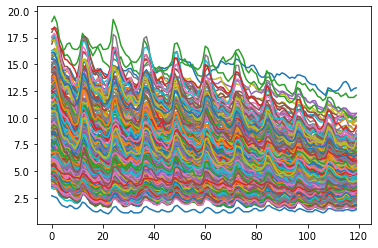

In [3]:
df_y_grouped = df.groupby('ags5')
for group, group_df in df_y_grouped:
    new_series = group_df.sort_values('date').reset_index(drop=True).drop(['date'], axis=1).copy()
    plt.plot(new_series)
plt.show()

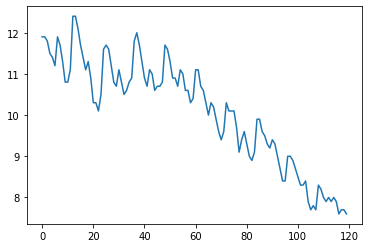

In [4]:
series = list(df_y_grouped.get_group(1004).sort_values('date').drop(['date'], axis=1).copy()['unemployment_rate'])
plt.plot(series)
plt.show()

### DATA IS VERY VERY SEASONAL!!!!!!!!!!!!!!!!!!!!!!!

# 401 Model for each kreis

In [5]:
# one-step sarima forecast
def sarima_forecast(history, config):
    order, sorder, trend = config
    # define model
    model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
    # fit model
    model_fit = model.fit(disp=False)
    # make one step forecast
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]

In [6]:
# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

In [7]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

In [8]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = sarima_forecast(history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    return error

In [9]:
# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
    result = None
    # convert config to a key
    key = str(cfg)
    # show all warnings and fail on exception if debugging
    if debug:
        result = walk_forward_validation(data, n_test, cfg)
    else:
            # one failure during model validation suggests an unstable config
        try:
            # never show warnings when grid searching, too noisy
            with catch_warnings():
                filterwarnings("ignore")
                result = walk_forward_validation(data, n_test, cfg)
        except:
            error = None
    # check for an interesting result
#     if result is not None:
#         print(' > Model[%s] %.3f' % (key, result))
        
    print('.', end='')
    return (key, result)

----------
!mlflow experiments create --experiment-name 401ModelsTemp

Created experiment '401ModelsTemp' with id 6

---------

In [ ]:
# data split
n_test = 12
# model config
cfg = [(1, 1, 2), (1, 0, 2, 12), 't']
# train 401 models
print("Training", end=' ')
failed_ags5 = []
rmse_scores = []

with mlflow.start_run(experiment_id=6):
    
    for ags5, df_for_kreis in df_y_grouped:
        
        data = list(df_for_kreis.sort_values('date').drop(['date'], axis=1).copy()['unemployment_rate'])
        
        try: 
        
            score = score_model(data, n_test, cfg)

            if score is None:
                raise Exception("No Score")
            
            rmse_scores.append(score[1])
            print('.', end='')
        except:
            failed_ags5.append(ags5)
            print('!', end='')
            
    params = {}
    params['p'], params['d'], params['q'] = cfg[0]
    params['s_p'], params['s_d'], params['s_q'], params['m'] = cfg[1]
    params['t'] = cfg[2]
    
    net_rmse = np.mean([rmse**2 for rmse in rmse_scores])**(0.5)
    
    
    mlflow.log_params(params)
    mlflow.log_metric('net_rmse', net_rmse)
      
    

print('\ndone')
print("Failed ags5:", failed_ags5)

Training ........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [ ]:
rmse_scores

In [ ]:
params